In [15]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split 
import shutil

In [16]:
# Set random seed for reproducibility
np.random.seed(1337)
tf.random.set_seed(1337)


In [17]:
# Part 1: Dataset Preparation
def prepare_data(input_dir, output_dir, test_size=0.2):
    # Filter out only the actual class directories (exclude 'train' and 'val')
    classes = [cls for cls in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, cls)) and cls not in ['train', 'val']]

    for cls in classes:
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = os.listdir(cls_path)
        train_images, val_images = train_test_split(images, test_size=test_size, random_state=1337)

        train_dir = os.path.join(output_dir, 'train', cls)
        val_dir = os.path.join(output_dir, 'val', cls)

        # Ensure directories exist
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        for img in train_images:
            img_path = os.path.join(cls_path, img)
            try:
                shutil.copy(img_path, os.path.join(train_dir, img))
            except PermissionError:
                print(f"Permission error while copying {img_path}")
                continue

        for img in val_images:
            img_path = os.path.join(cls_path, img)
            try:
                shutil.copy(img_path, os.path.join(val_dir, img))
            except PermissionError:
                print(f"Permission error while copying {img_path}")
                continue



In [18]:
# Input and output directory
input_dir = r'dataset'
output_dir = r'dataset/augmented'
prepare_data(input_dir, output_dir)


In [19]:
# Part 2: Load Pretrained Model and Build the Classifier

# Load MobileNetV2 pretrained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  

In [20]:
# Build the classifier
classifier = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  
])

In [21]:
# Compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(classifier.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [22]:
# Part 3: Data Augmentation and Image Generators

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

In [23]:
# Only rescale for the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [24]:

# Load training and testing data
training_set = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2420 images belonging to 4 classes.
Found 607 images belonging to 4 classes.


In [25]:
# Print class indices
label_map = training_set.class_indices
print(f"Class indices: {label_map}")


Class indices: {'Healthy': 0, 'Nitrogen': 1, 'Phosphorus': 2, 'Potassium': 3}


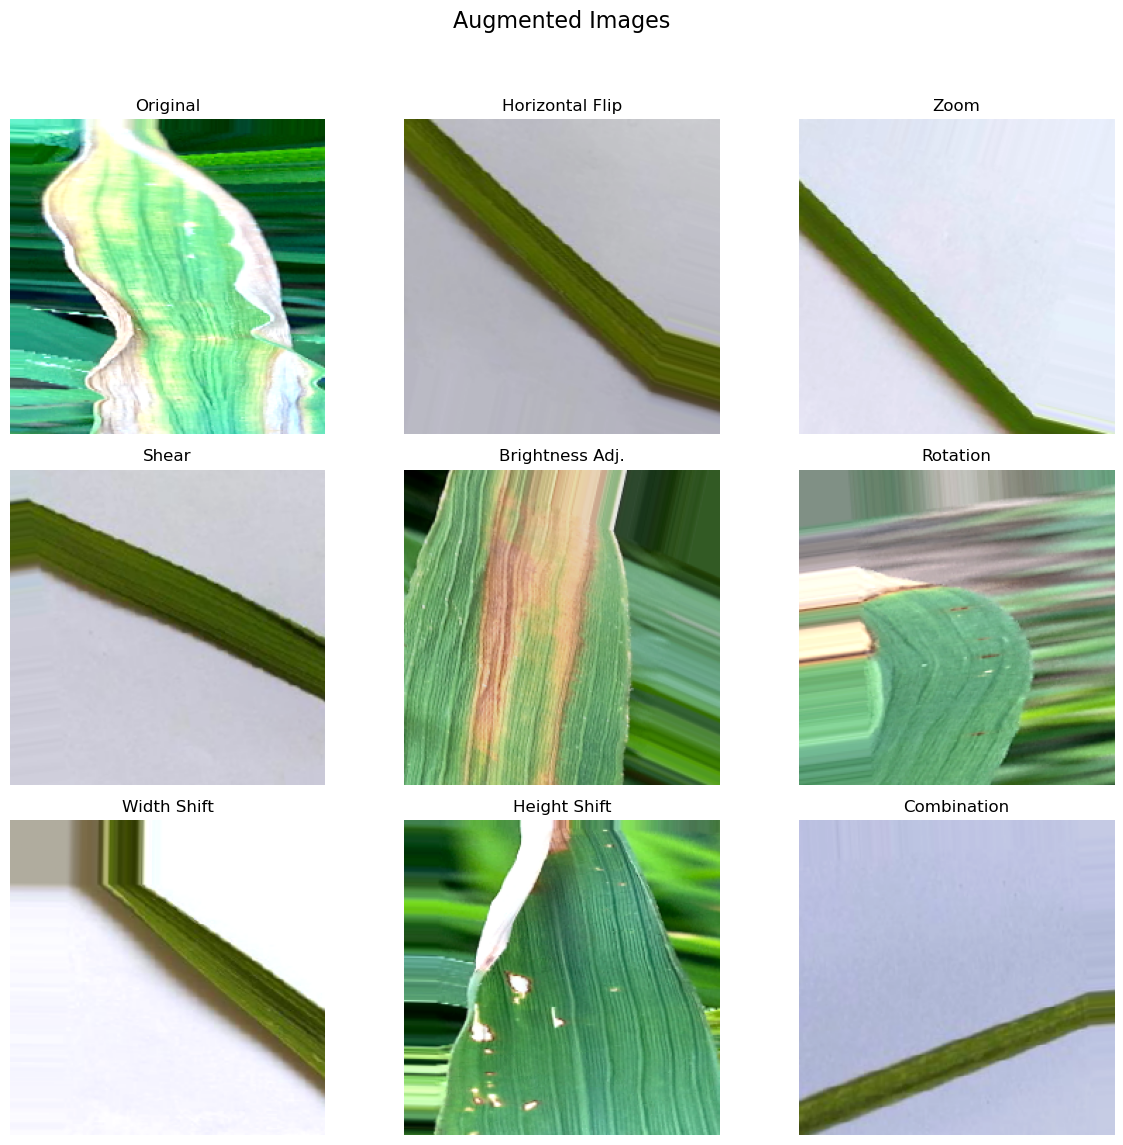

In [26]:
# Visualize augmented data
augmented_images, _ = next(training_set)
plt.figure(figsize=(12, 12))
plt.suptitle("Augmented Images", fontsize=16)
augmentation_titles = [
    "Original", "Horizontal Flip", "Zoom", "Shear", "Brightness Adj.",
    "Rotation", "Width Shift", "Height Shift", "Combination"
]

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(augmentation_titles[i % len(augmentation_titles)])
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [27]:
# Part 4: Train the Model with Callbacks

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [28]:
# Train the model
history = classifier.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=20,
    validation_data=test_set,
    validation_steps=test_set.samples // test_set.batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.7470 - loss: 0.5876 - val_accuracy: 0.9271 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.8438 - loss: 0.2866

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 503ms/step - accuracy: 0.8438 - loss: 0.2866 - val_accuracy: 0.9271 - val_loss: 0.2020 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.8950 - loss: 0.2444 - val_accuracy: 0.9514 - val_loss: 0.1472 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 417ms/step - accuracy: 0.8438 - loss: 0.2220 - val_accuracy: 0.9549 - val_loss: 0.1431 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9228 - loss: 0.1931 - val_accuracy: 0.9323 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 402ms/step - accuracy: 0.9375 - loss: 0.2226 - val_accuracy: 0.9288 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9196 - loss: 0.1937 - val_accuracy: 0.9566 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - accuracy: 0.9062 - loss: 0.2290 - val_accura

In [29]:

# Part 5: Evaluate the Model

# Evaluate on test data
predictions = classifier.predict(test_set, steps=test_set.samples // test_set.batch_size)
y_pred = np.argmax(predictions, axis=1)
y_true = test_set.classes[:len(y_pred)]


18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


In [30]:
# Calculate metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

F1 Score: 0.3521
Precision: 0.3568
Recall: 0.3490


In [31]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[151  44  33  70]
 [ 45   9  11  23]
 [ 33  11   5  18]
 [ 51  18  18  36]]


In [32]:
# Classification report
report = classification_report(y_true, y_pred, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.54      0.51      0.52       298
    Nitrogen       0.11      0.10      0.11        88
  Phosphorus       0.07      0.07      0.07        67
   Potassium       0.24      0.29      0.27       123

    accuracy                           0.35       576
   macro avg       0.24      0.24      0.24       576
weighted avg       0.36      0.35      0.35       576



In [33]:
# Part 6: Convert the Model to TensorFlow Lite (TFLite)

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpd4p4llf2\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpd4p4llf2\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpd4p4llf2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2383683243280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683243856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683244048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683243664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683243472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683244432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683245776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683245968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683245584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2383683244816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23

In [34]:
# Save the TFLite model
tflite_model_path = r'C:\Users\User\Documents\Tenserflow\rice_plant_lacks_nutrients.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TFLite model saved as {tflite_model_path}')


TFLite model saved as C:\Users\User\Documents\Tenserflow\rice_plant_lacks_nutrients.tflite
